In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
length = 10000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0 #(average of zero)
lst_dct = {col:[] for col in cols}
sigma = 5  #(standard deviation of 5)

In [2]:
lst_dct = {col:[] for col in cols}
for i in range(length):
    lst_dct["P"].append(25 + np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))
df = pd.DataFrame(lst_dct)
keys = cols 
df

,P,Q,X,Y,Z
0,22.931465,43.146543,126.908847,-52.042146,347.488036
1,21.885732,54.283829,168.103718,-49.160305,396.078980
2,26.480026,50.531108,154.762799,-47.414874,376.309063
3,20.173576,46.553345,139.274146,-42.513346,325.437484
4,20.802842,46.495100,140.837572,-56.004690,360.942438
...,...,...,...,...,...
9995,24.758748,42.743375,134.261606,-39.445641,330.813873
9996,26.156311,53.547414,168.694209,-62.372462,425.022953
9997,20.982223,42.717770,118.667968,-36.919572,291.198581
9998,26.093704,44.393394,139.158899,-37.762439,338.502132


<AxesSubplot:xlabel='Q', ylabel='Z'>

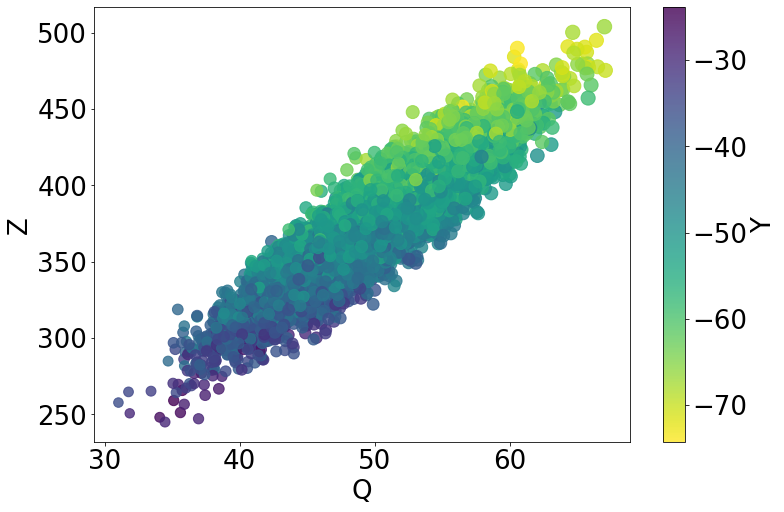

In [3]:
plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (12,8))
df.plot.scatter(x = "Q", y = "Z", c = "Y",s = "X", cmap = "viridis_r",alpha = .8, ax = ax)

In [4]:
df.corr()

,P,Q,X,Y,Z
P,1.000000,-0.014894,-0.014970,0.015902,0.123697
Q,-0.014894,1.000000,0.948328,-0.706282,0.914148
X,-0.014970,0.948328,1.000000,-0.671785,0.934272
Y,0.015902,-0.706282,-0.671785,1.000000,-0.847077
Z,0.123697,0.914148,0.934272,-0.847077,1.000000


In [5]:
import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [6]:
residuals

,P,Q,X,Y,Z
0,-2.794655,-0.773255,-4.017728,1.029554,6.933674
1,-2.060305,-0.592850,0.714374,1.831040,1.998363
2,1.606363,-0.533768,2.626635,-0.751499,-3.468359
3,-0.226359,0.169377,4.034712,-2.692300,-8.849847
4,-1.066748,-1.540537,2.337929,-3.487186,-4.138244
...,...,...,...,...,...
9995,-0.452987,-2.032378,1.348574,1.154929,1.182924
9996,1.877414,-2.651663,4.834917,-3.727220,-5.046443
9997,-1.377472,2.433023,-1.615958,0.070396,-2.742997
9998,-0.065453,-1.570581,0.817476,2.252696,2.306882


In [7]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,P,Q,X,Y,Z
P,1.00,-0.01,-0.59,0.63,0.71
Q,-0.01,1.00,0.49,-0.12,0.01
X,-0.59,0.49,1.00,0.74,0.83
Y,0.63,-0.12,0.74,1.00,-0.90
Z,0.71,0.01,0.83,-0.90,1.00


In [8]:
import pingouin
df.corr().round(2)

,P,Q,X,Y,Z
P,1.00,-0.01,-0.01,0.02,0.12
Q,-0.01,1.00,0.95,-0.71,0.91
X,-0.01,0.95,1.00,-0.67,0.93
Y,0.02,-0.71,-0.67,1.00,-0.85
Z,0.12,0.91,0.93,-0.85,1.00


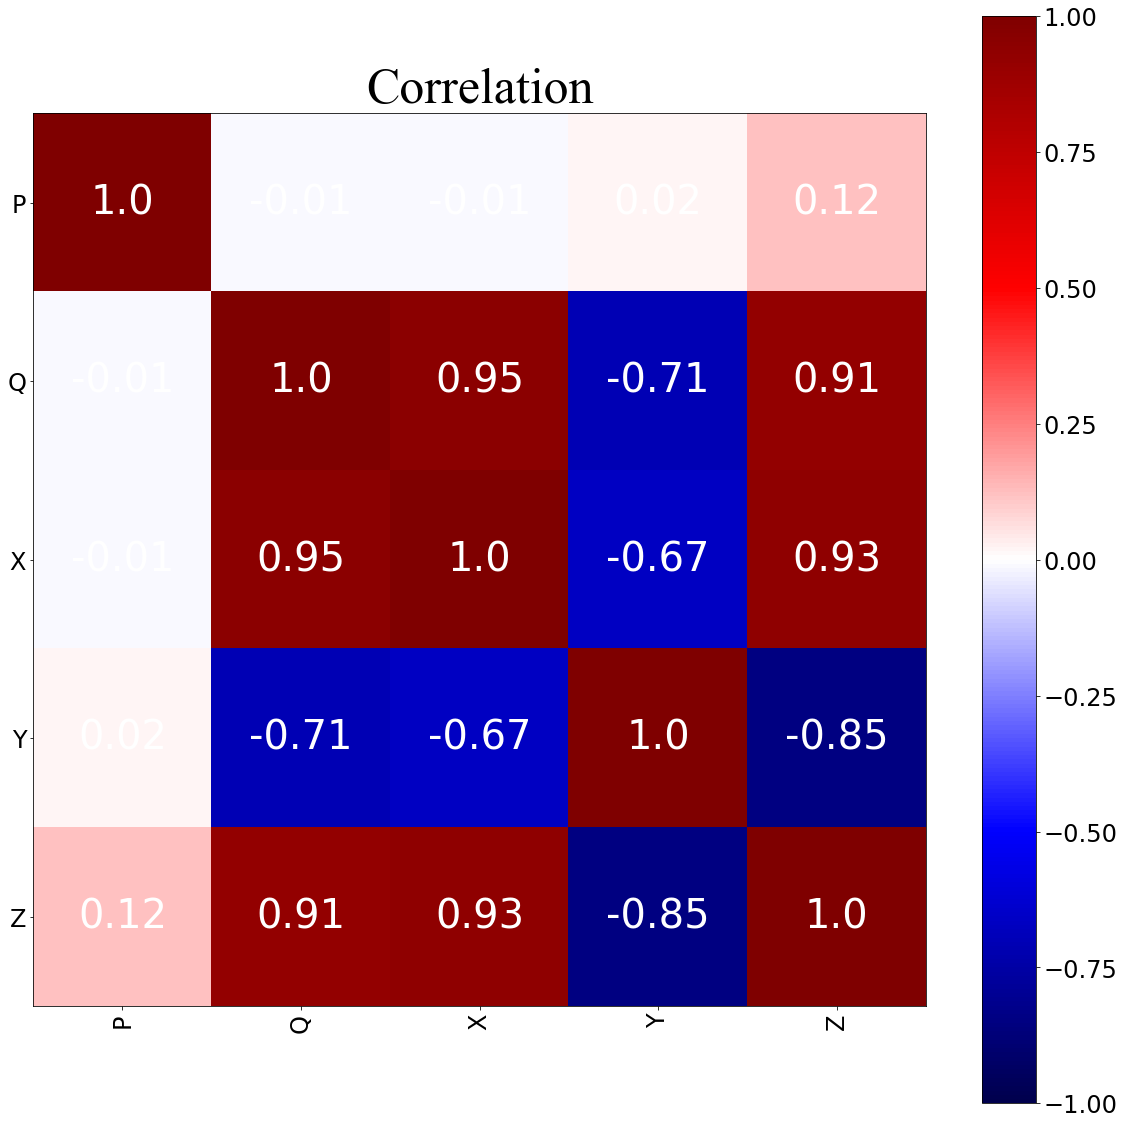

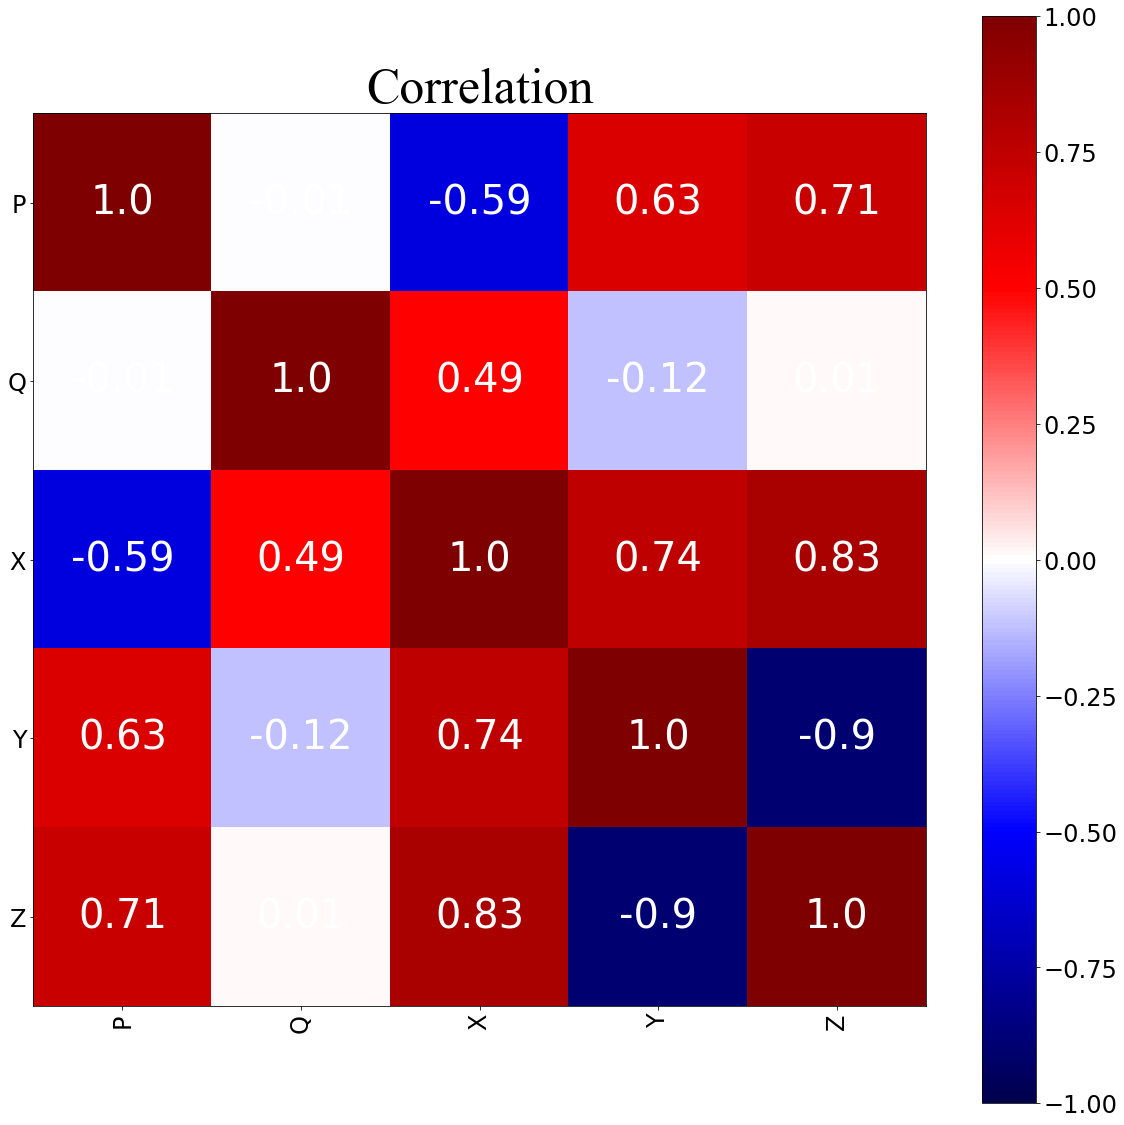

In [9]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None, 
                    #title = "Correlation"
                   )

corr_matrix_heatmap(df.pcorr(), 
                    save_fig = False, 
                    pp = None, 
                    #title = "Partial Correlation"
                   )

In [10]:
pcorr_pvalues = {}

for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            # this will regress one residual on the other, save the pvalue for the explanatory variable
            # and create a pvalue partial correlation
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,P,Q,X,Y,Z
P,NaN,0.45,0.0,0.0,0.00
Q,0.45,NaN,0.0,0.0,0.27
X,0.00,0.00,NaN,0.0,0.00
Y,0.00,0.00,0.0,NaN,0.00
Z,0.00,0.27,0.0,0.0,NaN


In [11]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    undirected_graph[x] = [y for y in df.keys() if y != x]
undirected_graph

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [12]:
import copy
p_val = 0.01
def build_skeleton(df, undirected_graph):
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                # recursive function that iterates through remaining variables 
                #  uses them as controls statistical significance holds without them,
                #  otherwise break
                #print(sorted(list(set(c_used))))
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)

    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x !=y:
                test = df.partial_corr(x=x,
                                      y=y,
                                      covar=None,
                                      method="pearson")
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
                else:
                    control_vars = [z for z in df.keys() if z !=y and z !=x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

print(build_skeleton(df, undirected_graph))

{'P': ['Z'], 'Q': ['X', 'Y'], 'X': ['Q', 'Z'], 'Y': ['Q', 'Z'], 'Z': ['P', 'X', 'Y']}


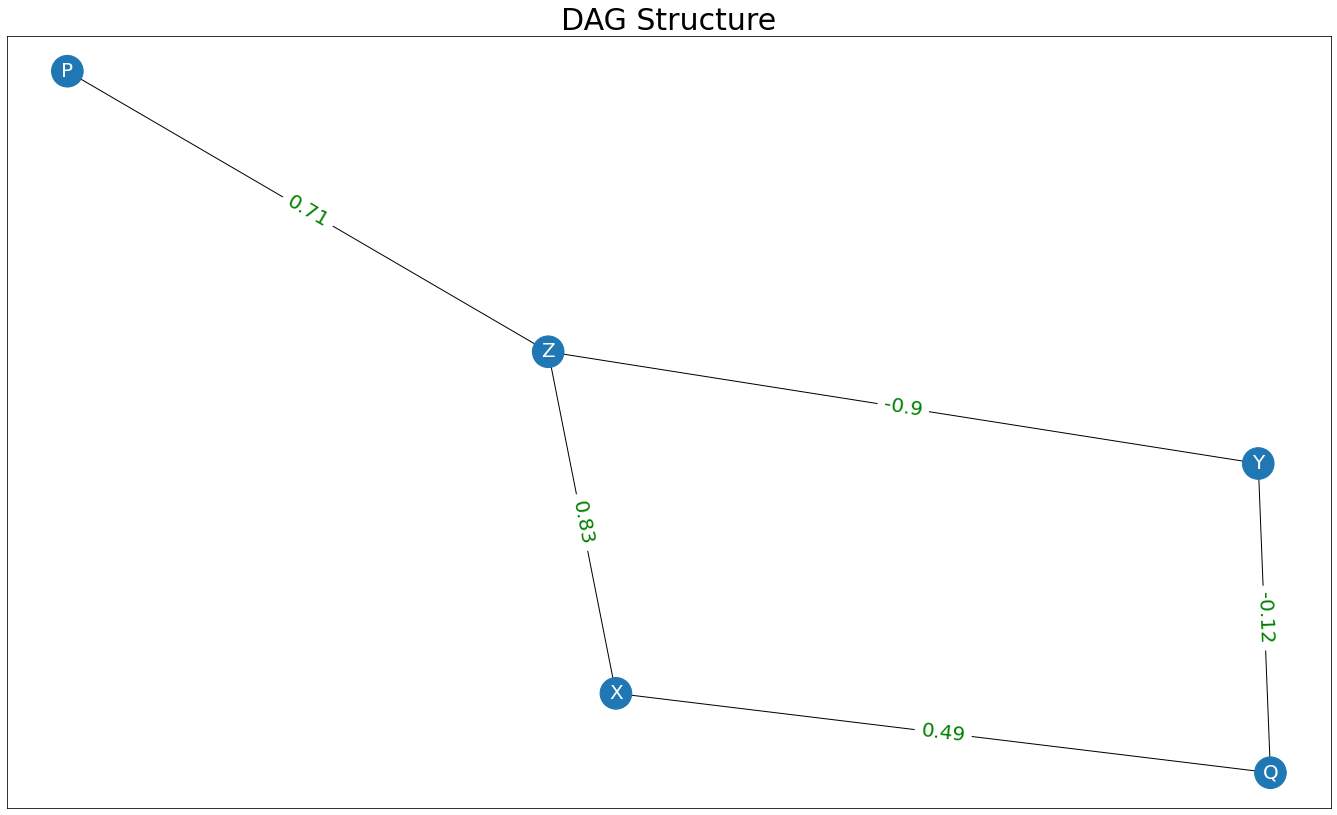

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))
    
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
    
    fix, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layouut(graph)
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  
                     arrows=False,
                     font_size = 20, 
                     alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    
    
    plt.show()
    
graph_DAG(undirected_graph, df)

In [14]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2
model = c.estimate(return_type = "dag",
                   variant= "parallel",    #"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, 
                   ci_test = "pearsonr")
edges = model.edges()
edges

  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('Y', 'Z'), ('X', 'Z'), ('P', 'Z'), ('Q', 'Y'), ('Q', 'X')])

keep control: P
('Y', 'Z') ['P']
('Y', 'Z') ['P']
keep control: X
('Y', 'Z') ['P', 'X']
keep control: P
('X', 'Z') ['P']
keep control: Y
('X', 'Z') ['P', 'Y']
('X', 'Z') ['P', 'Y']
keep control: Y
('P', 'Z') ['Y']
('P', 'Z') ['Y']
keep control: X
('P', 'Z') ['Y', 'X']
('Q', 'Y') []
('Q', 'Y') []
('Q', 'Y') []
('Q', 'X') []
('Q', 'X') []
('Q', 'X') []


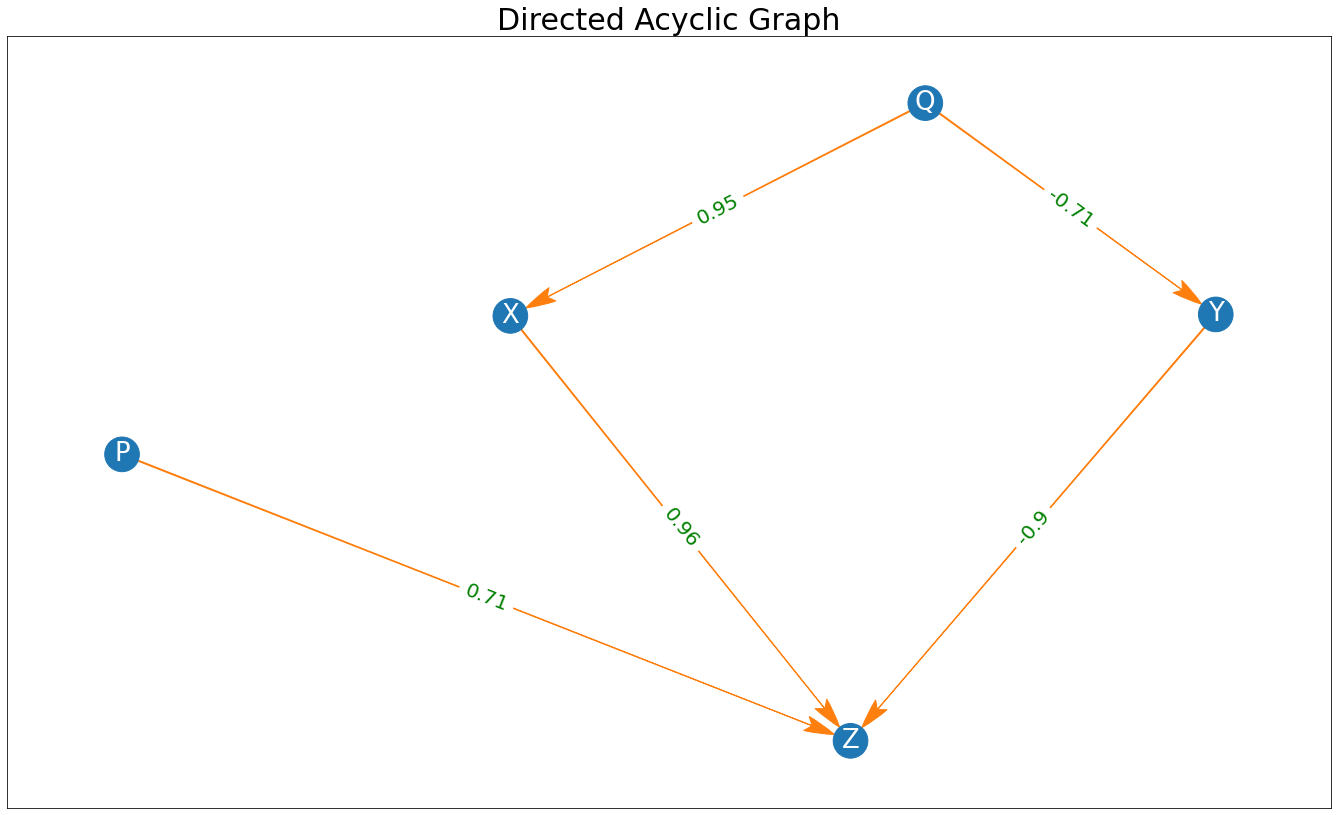

In [15]:
from matplotlib.patches import ArrowStyle
def graph_DAG(edges, df, title=""):
    graph = nx.DiGraph()
    
    edge_labels ={}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)
            print(edge, keep_controls)
            
            #build pcorr matrix with nodes from the edges + controls
            
            pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
            
            #edge_labels[edge] = str(pcorr.loc[edge[0]], edge[0])
            
            edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    
    
    graph.add_edges_from(edges)
    color_map =["C0" for g in graph]
    
    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=color_map, 
                     node_size = 1200,
                     font_color = "white",
                     font_size = 26, 
                     alpha = 1,
                     width = 1, 
                     edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels = edge_labels,
                                 font_color = "green",
                                 font_size = 20)
    
    plt.show()
graph_DAG(edges, df, title = "Directed Acyclic Graph")